# **Hands On Graph Neural Networks Using Python  -  CHAPTER 8**


- This code demonstrates a workflow for working with graph neural networks using PyTorch Geometric. It begins by setting up reproducibility with random seeds.

- The GraphDataset class handles loading and printing details about a dataset, while GraphVisualizer plots subgraphs from a data loader. The GraphSAGEModel class implements a GraphSAGE model for node classification, including training and testing methods.

- In the example usage section, it initializes and trains the GraphSAGE model on a Planetoid dataset, visualizes subgraphs, and evaluates the model's performance.

- It also includes code to load and prepare data from the PPI dataset, defines and trains a PyTorch Geometric GraphSAGE model with additional training and evaluation loops, and calculates F1 scores for performance metrics

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid, PPI
from torch_geometric.loader import NeighborLoader, DataLoader
from torch_geometric.nn import SAGEConv, GraphSAGE as PyGGraphSAGE

### **RandomSeedSetup Class**

- This class is responsible for setting up the random seed for reproducibility in experiments.

- It initializes the seed for both CPU and GPU operations and configures PyTorch's cuDNN backend to ensure deterministic behavior.

- This helps to ensure that results are consistent across different runs of the code.

In [2]:
class RandomSeedSetup:
    def __init__(self, seed=0):
        self.seed = seed
        self.setup()

    def setup(self):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

### **GraphDataset Class**

- The GraphDataset class is designed to handle loading and managing graph datasets.

- It specifically loads the Planetoid dataset and provides methods to print dataset information such as the number of graphs, nodes, features, and classes.

- It also includes a method to create a NeighborLoader for sampling subgraphs during training

In [3]:
class GraphDataset:
    def __init__(self, dataset_name):
        self.dataset = Planetoid(root='.', name=dataset_name)
        self.data = self.dataset[0]

    def print_dataset_info(self):
        print(f'Dataset: {self.dataset}')
        print('-------------------')
        print(f'Number of graphs: {len(self.dataset)}')
        print(f'Number of nodes: {self.data.x.shape[0]}')
        print(f'Number of features: {self.dataset.num_features}')
        print(f'Number of classes: {self.dataset.num_classes}')

        print(f'\nGraph:')
        print('------')
        print(f'Training nodes: {sum(self.data.train_mask).item()}')
        print(f'Evaluation nodes: {sum(self.data.val_mask).item()}')
        print(f'Test nodes: {sum(self.data.test_mask).item()}')
        print(f'Edges are directed: {self.data.is_directed()}')
        print(f'Graph has isolated nodes: {self.data.has_isolated_nodes()}')
        print(f'Graph has loops: {self.data.has_self_loops()}')

    def create_loader(self):
        return NeighborLoader(
            self.data,
            num_neighbors=[5, 10],
            batch_size=16,
            input_nodes=self.data.train_mask,
        )


### **GraphVisualizer Class**

- The GraphVisualizer class is used for visualizing subgraphs from a data loader.

- It plots each subgraph using NetworkX and Matplotlib, allowing you to visually inspect the structure and features of the graphs in the dataset.

- This is useful for understanding the data and debugging.


In [4]:
class GraphVisualizer:
    def __init__(self, train_loader):
        self.train_loader = train_loader

    def plot_subgraphs(self):
        fig = plt.figure(figsize=(16,16))
        for idx, (subdata, pos) in enumerate(zip(self.train_loader, [221, 222, 223, 224])):
            G = to_networkx(subdata, to_undirected=True)
            ax = fig.add_subplot(pos)
            ax.set_title(f'Subgraph {idx}', fontsize=24)
            plt.axis('off')
            nx.draw_networkx(G,
                            pos=nx.spring_layout(G, seed=0),
                            with_labels=False,
                            node_color=subdata.y,
                            )
        plt.show()

### **GraphSAGEModeln Class**

- The GraphSAGEModel class defines a GraphSAGE model using the SAGEConv layers from PyTorch Geometric.

- It includes methods for forward propagation (forward), training (fit), and testing (test).

- The fit method trains the model using cross-entropy loss and Adam optimizer, while the test method evaluates the model's performance on the test set.

- It also includes a helper method to calculate accuracy.

In [5]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += self.accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += self.accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(loader):.2f} | Val Acc: {val_acc/len(loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = self.accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

    def accuracy(self, pred_y, y):
        return ((pred_y == y).sum() / len(y)).item()

### **PPIDataLoader Class**

- The PPIDataLoader class is responsible for loading and preparing the PPI (Protein-Protein Interaction) datasets for training, validation, and testing.

- It manages the dataset loading and the creation of data loaders with specific configurations for neighbor sampling and batching.

- This class abstracts away the details of dataset management and data loading, making it easier to integrate with the rest of the code.

In [6]:
class PPIDataLoader:
    def __init__(self, batch_size=2048):
        self.batch_size = batch_size
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def load_datasets(self):
        self.train_dataset = PPI(root=".", split='train')
        self.val_dataset = PPI(root=".", split='val')
        self.test_dataset = PPI(root=".", split='test')

    def create_loaders(self):
        train_data = Batch.from_data_list(self.train_dataset)
        self.train_loader = NeighborLoader(
            train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_neighbors=[20, 10],
            num_workers=2,
            persistent_workers=True
        )
        self.val_loader = DataLoader(self.val_dataset, batch_size=2)
        self.test_loader = DataLoader(self.test_dataset, batch_size=2)


### **GraphSAGETrainer Class**

- The GraphSAGETrainer class handles the training and evaluation of the GraphSAGE model.

- It manages the model's lifecycle, including setting up the model, training it over multiple epochs, and evaluating its performance.

- This class simplifies the training and evaluation process by encapsulating the related functionality into methods, making the code cleaner and easier to maintain.

In [7]:
class GraphSAGETrainer:
    def __init__(self, train_loader, val_loader, test_loader, device):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.model = None
        self.optimizer = None
        self.criterion = None

    def setup_model(self, in_channels, hidden_channels, out_channels):
        self.model = PyGGraphSAGE(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            num_layers=2,
            out_channels=out_channels
        ).to(self.device)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.005)

    def fit(self, epochs):
        self.model.train()
        total_loss = 0
        for epoch in range(epochs+1):
            epoch_loss = 0
            for data in self.train_loader:
                data = data.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data.x, data.edge_index)
                loss = self.criterion(out, data.y)
                epoch_loss += loss.item() * data.num_graphs
                loss.backward()
                self.optimizer.step()
            total_loss = epoch_loss / len(self.train_loader.data)
            val_f1 = self.test(self.val_loader)
            if epoch % 50 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.3f} | Val F1-score: {val_f1:.4f}')

    @torch.no_grad()
    def test(self, loader):
        self.model.eval()
        data = next(iter(loader))
        out = self.model(data.x.to(self.device), data.edge_index.to(self.device))
        preds = (out > 0).float().cpu()
        y, pred = data.y.numpy(), preds.numpy()
        return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

    def evaluate(self):
        test_f1 = self.test(self.test_loader)
        print(f'Test F1-score: {test_f1:.4f}')

### **Main Code**

In [8]:
seed_setup = RandomSeedSetup(seed=-1)                                                         # Setup random seeds
dataset_handler = GraphDataset("Pubmed")                                                      # Load and print dataset information
dataset_handler.print_dataset_info()
train_loader = dataset_handler.create_loader()                                                # Create train loader

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


### **Visualize subgraphs**

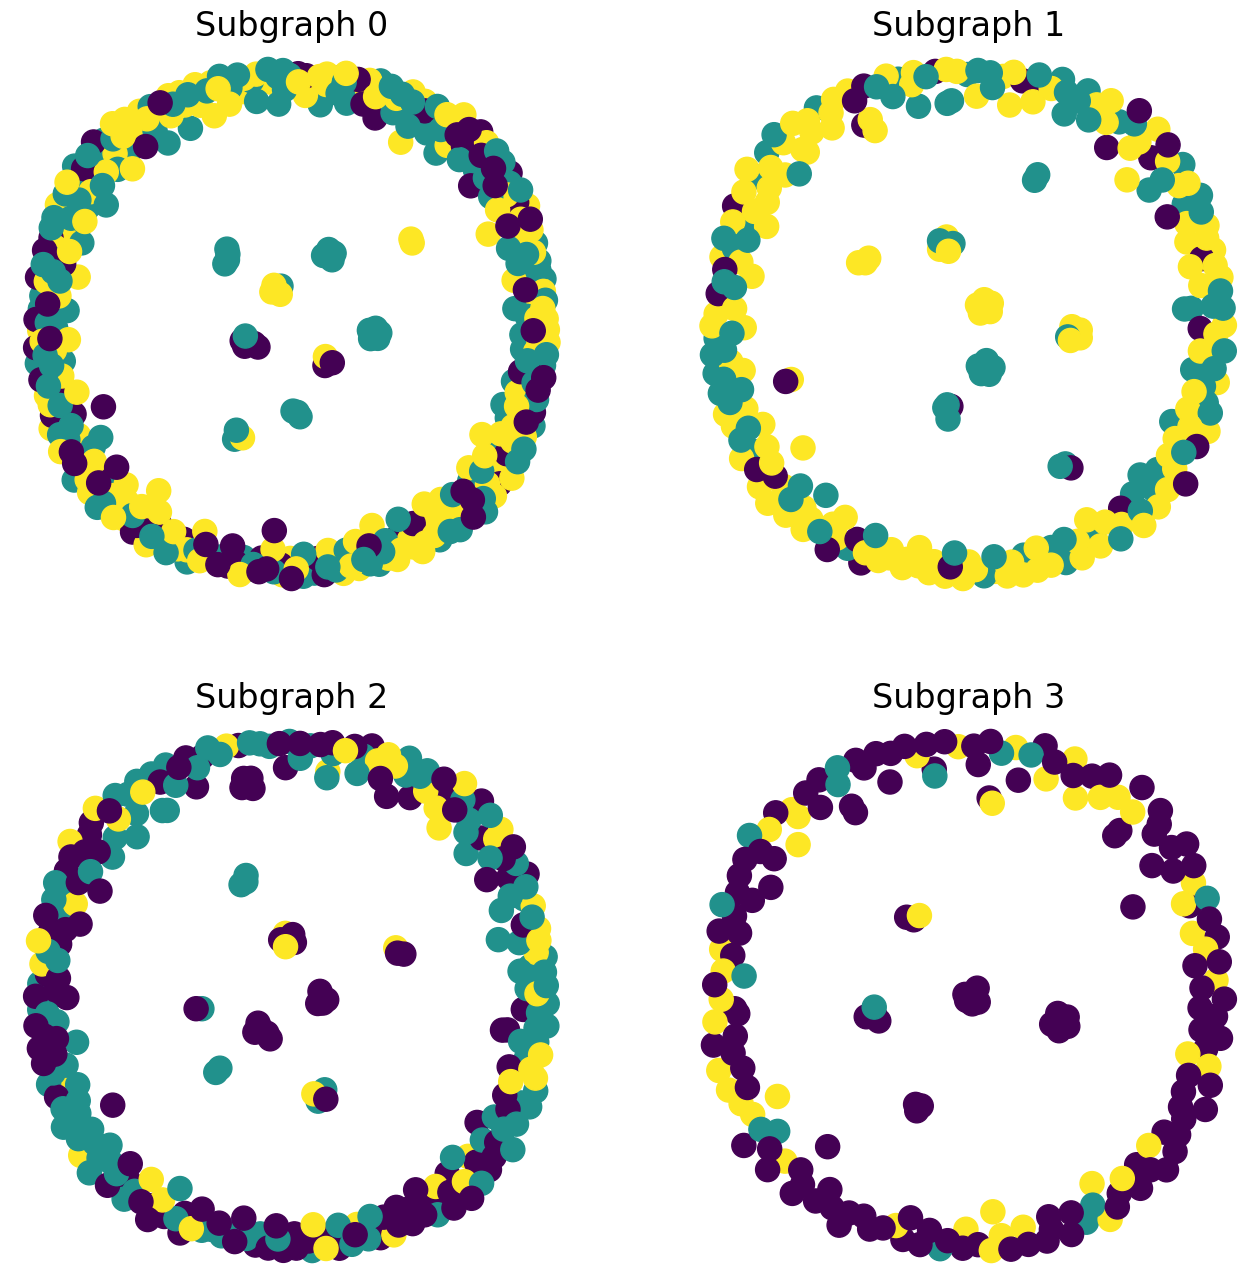

In [9]:
visualizer = GraphVisualizer(train_loader)
visualizer.plot_subgraphs()

### **Create and train GraphSAGE model**

In [10]:
graphsage_model = GraphSAGEModel(dataset_handler.dataset.num_features, 64, dataset_handler.dataset.num_classes)
print(graphsage_model)
graphsage_model.fit(train_loader, 200)
acc = graphsage_model.test(dataset_handler.data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGEModel(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.288 | Train Acc:  10.29% | Val Loss: 1.11 | Val Acc: 6.25%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 82.50%
Epoch  40 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 78.93%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 76.35%
Epoch  80 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.42 | Val Acc: 78.12%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.30 | Val Acc: 82.77%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 71.75%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 69.70%
Epoch 160 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.35 | Val Acc: 85.23%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 80.42%
Epoch 200 | Train Loss: 0.000 | Train Acc: 10